# Deep learning for time-series - Assignment 1

## Part A

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import norm
import warnings

### A1. Exploratory analysis
- Plot $y_t$ over time (clear labels). Describe trend/level changes/outliers.
- Add a simple smoothing overlay (moving average or exponential smoothing) only to highlight
structure (do not use it as the final model).

In [37]:
# Load data
df_raw = pd.read_csv("www_usage.csv")

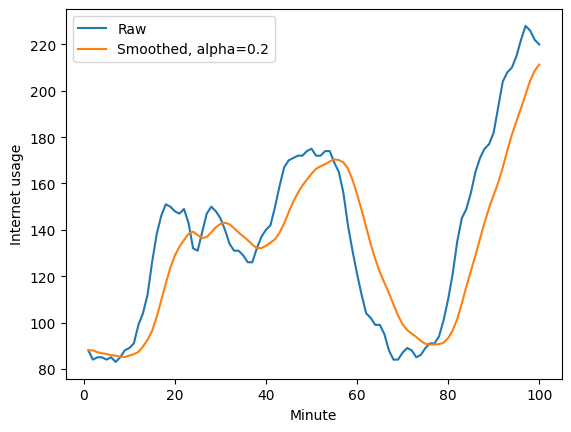

In [40]:
df = df_raw.copy()

# Fit exponential smoothing
model = SimpleExpSmoothing(df["y"])
alpha = 0.2
fit = model.fit(smoothing_level=alpha, optimized=False)
y_smooth = fit.fittedvalues

# Plot raw and smoothed series
plt.plot(df["ds"], df["y"], label="Raw")
plt.plot(df["ds"], y_smooth, label=f"Smoothed, alpha={alpha}")
plt.xlabel("Minute")
plt.ylabel("Internet usage")
plt.legend()
plt.show()

The dataset looks non-stationary in both a strict and wide sense. It exhibits significant positive and negative trends in mean with slightly noisy behaviour. It is difficult to access whether the series is heteroscedastic through visual inspection and it does not seem to contain notable outliers.

The smoothed signal shows same non-stationarity but the seemingly noisy part is filtered out.

### A2. Select the differencing order $d$
- Test $d=0, 1, 2$ in order. For each candidate: plot the differenced series and its ACF.
- Run stationarity tests: ADF (null: unit root / nonstationary) and KPSS (null: stationary).
- Choose the smallest d that makes the series look stationary and passes tests reasonably (avoid
over-differencing).
- Write 3–6 sentences explaining why your chosen d is appropriate.

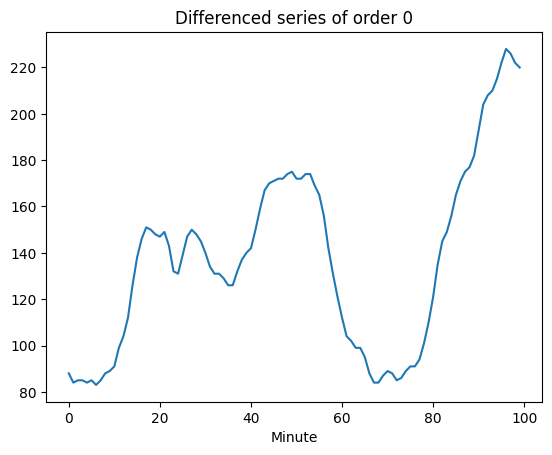

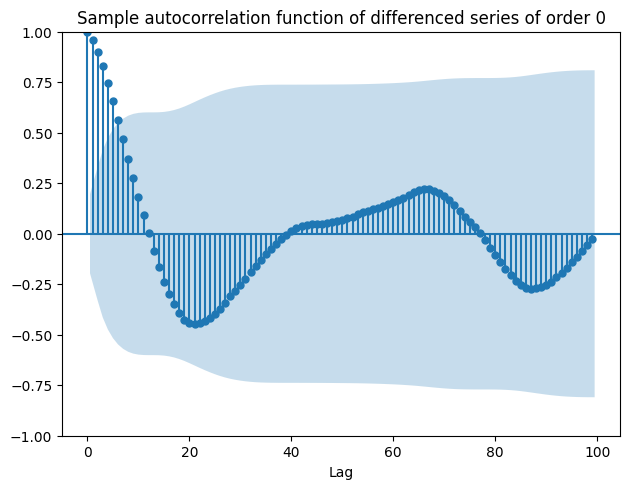

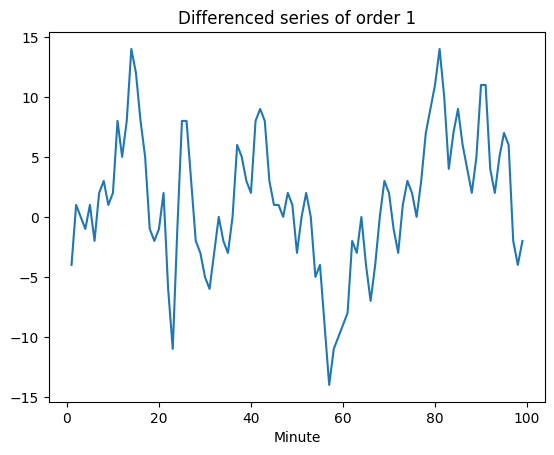

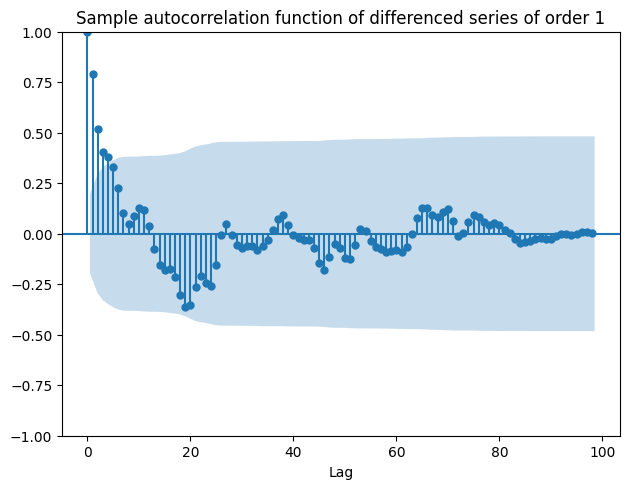

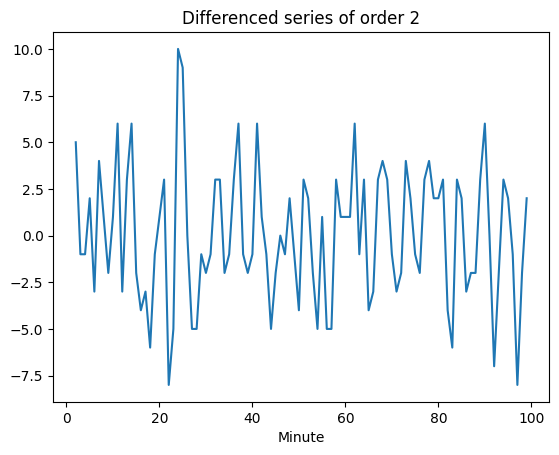

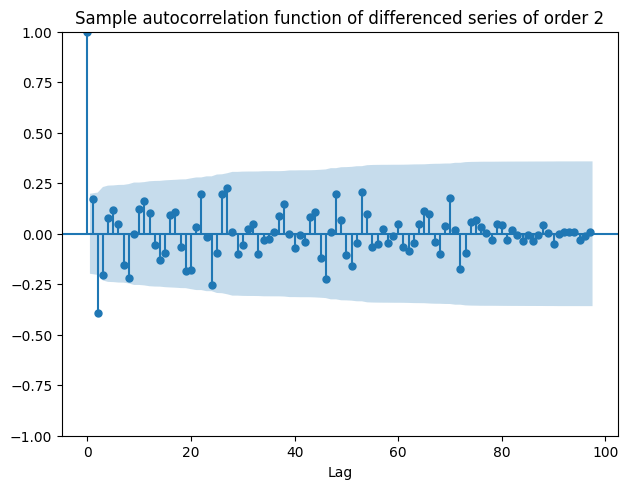

In [42]:
# Calculate differenced series
series = {}
series["0"] = df.y
series["1"] = df.y.diff().dropna()
series["2"] = series["1"].diff().dropna()

# Plot differenced series and corresponding sample ACFs
for key, value in series.items():
    plt.figure()
    plt.plot(value)
    plt.title("Differenced series of order "+str(key))
    plt.xlabel("Minute")
    plt.show()

    plot_acf(value, lags=len(value)-1)
    plt.tight_layout()
    plt.xlabel("Lag")
    plt.title("Sample autocorrelation function of differenced series of order "+str(key))

In [45]:
def stationarity_tests(series, name=""):
    # Applies ADF and KPSS tests

    # Ignore warnings on non-representative p-values
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        adf_stat, adf_p, *_ = adfuller(series)
        kpss_stat, kpss_p, *_ = kpss(series)

    return {
        "series": name,
        "adf_stat": adf_stat,
        "adf_p": adf_p,
        "kpss_stat": kpss_stat,
        "kpss_p": kpss_p
    }


results = []
for key, value in series.items():
    results.append(stationarity_tests(value, "Diff order "+key))
results = pd.DataFrame(results)

results

,series,adf_stat,adf_p,kpss_stat,kpss_p
0,Diff order 0,-2.464240,1.244194e-01,0.389007,0.081894
1,Diff order 1,-2.722238,7.026846e-02,0.167290,0.100000
2,Diff order 2,-9.929762,2.843429e-17,0.074949,0.100000


The plots of the ACFs show significant correlations for lags larger than 0 for the 0th- and 1st-order differenced series while the 2nd-order differenced series shows low autocorrelation for lags larger than 0.

The ADF test rejects the null hypothesis of a unit root at a 95% significance level for the 2nd-order differenced series while it does not for the 0th- and 1st-order differenced series. This suggests stationarity for the 2nd-order differenced series. The statistic for the 1st-order differenced series is however close to the significance threshold.

The KPSS does not reject the null hypothesis at a 95% significance level for any of the series but the p-values might be inflated from few samples.

From visual inspection of the plots of the time series and the ACFs in conjunction with the ADF and KPSS test a differencing order of $d=1$ is chosen. An order of 2 is not chosen in order to avoid over differencing and removing dependency between samples for the autoregressive part of the model to properly work.

### A3. Select $p$ and $q$ (AR and MA orders)
- Using the series after differencing with your chosen $d$, plot ACF and PACF (choose a sensible
number of lags).
- Propose a small set of candidate $(p, q)$ values based on ACF/PACF patterns (e.g., p up to 6, q up
to 4).
- Fit a grid of ARIMA($p$, $d$, $q$) models for those candidates and compare AIC and BIC.
- Pick a final model using a parsimony rule: prefer the simplest model with competitive BIC and
good diagnostics.


In [51]:
p_values = range(0, 4)  # AR orders
d = 1
q_values = range(0, 8)  # MA orders

results = []

warnings.filterwarnings("ignore")  # suppress convergence warnings

for p in p_values:
    for q in q_values:
        try:
            model = ARIMA(df.y, order=(p, d, q))
            model_fit = model.fit()
            results.append({
                'p': p,
                'd': d,
                'q': q,
                'AIC': model_fit.aic,
                'BIC': model_fit.bic
            })
        except:
            continue

results_df = pd.DataFrame(results)

# Sort by BIC
results_df = results_df.sort_values('BIC').reset_index(drop=True)
results_df.head(5)

,p,d,q,AIC,BIC
0,1,1,1,514.300254,522.085614
1,3,1,0,511.994816,522.375295
2,1,1,2,516.252648,526.633128
3,2,1,1,516.292220,526.672700
4,3,1,1,513.938500,526.914099


### A4. Estimate parameters (MLE) and interpret
- Fit the selected ARIMA model using statsmodels. Report parameter estimates and standard
errors.
- Explain in simple terms what maximum likelihood estimation is doing for ARIMA. (You may
mention that statsmodels evaluates the likelihood via a state-space/Kalman filter implementation.)

In [54]:
orders = (3, 1, 0)
model = ARIMA(df.y, order=orders)
model_fit = model.fit()

results = pd.DataFrame({
    "estimate": model_fit.params,
    "std_error": model_fit.bse
})

results

,estimate,std_error
ar.L1,1.151339,0.102672
ar.L2,-0.661223,0.134078
ar.L3,0.340715,0.093584
sigma2,9.363310,1.368681


MLE is used for parameter estimation in ARIMA models and the parameters are estimated under the assumption that the residuals are normally distributed. The likelihood function with this distribution can then be maximised with respect to the parameters and according to the observed data.

The Kalman filter is used for efficient computation since the ARIMA model can be represented as a state-space model where the recursive moving average part is implicitely included in the state-space representation and where the noise is Gaussian. The Kalman filter is suitable because of the assumption of normally distributed noise in the state-space model.

For this particular choice of model parameters (moving average order of 0) the Kalman filter is not needed for efficient estimation. OLS or Yule-Walker could then be used for efficient estimation.

### A5. Residual diagnostics (white-noise check)
- Plot residuals and residual ACF.
- Run Ljung–Box at several lags (e.g., 10 and 20) and interpret the p-values.
- If residuals are not white noise, describe one concrete model revision (change p/q, revisit d, etc.)
and justify.


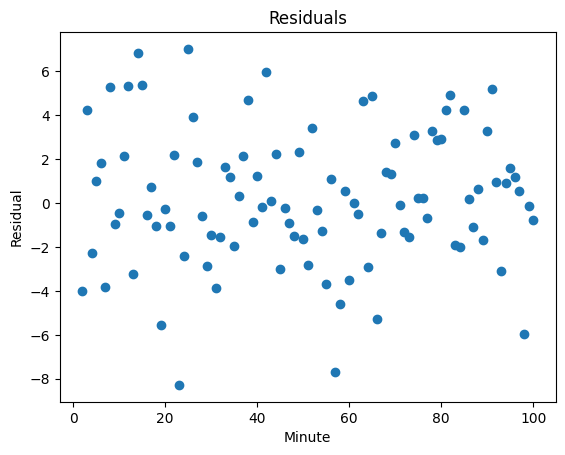

<Figure size 640x480 with 0 Axes>

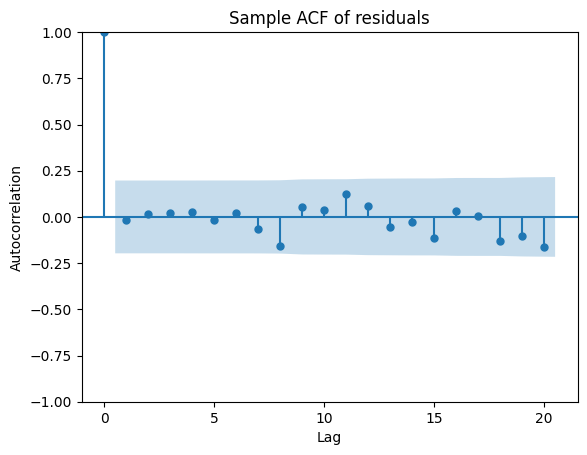

In [55]:
residuals = df.y - model_fit.predict()
residuals = residuals[1:]

plt.figure()
plt.scatter(df.ds[1:], residuals)
plt.title("Residuals")
plt.xlabel("Minute")
plt.ylabel("Residual")
plt.show()

plt.figure()
plot_acf(residuals)
plt.title("Sample ACF of residuals")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()


In [56]:
# Ljung-Box test for lags 10 and 20
lb_test = acorr_ljungbox(residuals, lags=20)
lb_test.loc[[10, 20]]

,lb_stat,lb_pvalue
10,3.956673,0.949280
20,14.861316,0.784287


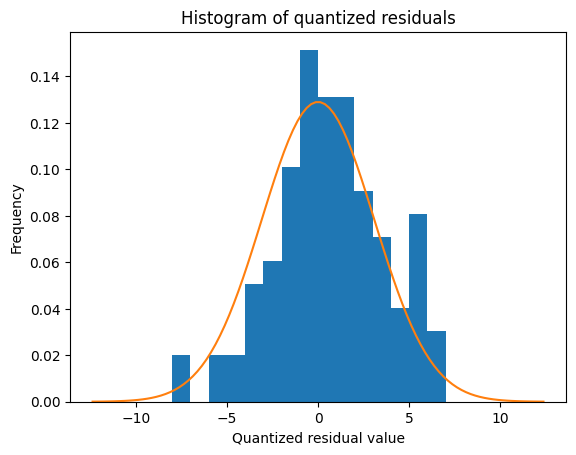

In [16]:
# Quantization step (bin width)
q = 1

# Quantize residuals
quantized = np.round(residuals / q) * q

# Normal distibution
mu, sigma = 0, np.std(quantized)
# Data range
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
# PDF
y = norm.pdf(x, mu, sigma)

# Plot histogram
plt.figure()
plt.hist(quantized, bins=len(quantized.unique()), density=True)
plt.plot(x, y)
plt.xlabel("Quantized residual value")
plt.ylabel("Frequency")
plt.title("Histogram of quantized residuals")
plt.show()

The residuals seem from visual inspection to be uncorrelated in time, the Ljung-Box test does not reject the null-hypothesis of no correlation at a 95% significance level and the residuals are approximately normally distributed. The residuals therefore resemble white noise and the assumed noise in the model and do not provide motivation for changing the model radically.

### A6. Forecasting validaation (hold-out)
- Hold out the last h = 20 observations as a test set. Fit your ARIMA model on the remaining data.
- Forecast h steps ahead with 95% prediction intervals. Plot train/test/forecast clearly.
- Compute MAE and RMSE on the test set.
- Compare against a naive baseline (repeat the last training value) and briefly interpret the results

In [58]:
df = df_raw.copy()

# Divide into train and test sets
h = 20
train = df.y.iloc[:-h]
test  = df.y.iloc[-h:]

# Fit ARIMA
order = (3, 1, 0)
model = ARIMA(train, order=order)
fitted = model.fit()

print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -202.280
Date:                Wed, 25 Feb 2026   AIC                            412.560
Time:                        01:26:00   BIC                            422.038
Sample:                             0   HQIC                           416.357
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1057      0.110     10.037      0.000       0.890       1.322
ar.L2         -0.5786      0.140     -4.141      0.000      -0.852      -0.305
ar.L3          0.2645      0.107      2.470      0.0

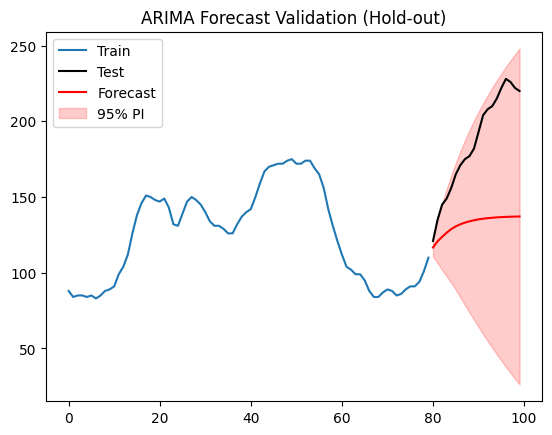

In [21]:
forecast_res = fitted.get_forecast(steps=h)

forecast = forecast_res.predicted_mean
conf_int = forecast_res.conf_int(alpha=0.05)


plt.plot(train, label="Train")
plt.plot(test, label="Test", color="black")
plt.plot(forecast, label="Forecast", color="red")

plt.fill_between(
    conf_int.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color="red",
    alpha=0.2,
    label="95% PI"
)

plt.legend()
plt.title("ARIMA Forecast Validation (Hold-out)")
plt.show()

In [25]:
mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast)

naive_forecast = np.repeat(train.iloc[-1], h)
naive_mae = mean_absolute_error(test, naive_forecast)
naive_rmse = mean_squared_error(test, naive_forecast)

print(f"ARIMA MAE  = {mae:.3f}")
print(f"ARIMA RMSE = {rmse:.3f}")

print(f"Naive MAE  = {naive_mae:.3f}")
print(f"Naive RMSE = {naive_rmse:.3f}")

ARIMA MAE  = 53.928
ARIMA RMSE = 3640.395
Naive MAE  = 76.200
Naive RMSE = 6858.700


## Part B

### B1. OLS baseline + diagnose residual autocorrelation
- Fit OLS: $y_t = c + β x_t + e_t$ ($y$ = consumption growth, $x$ = income growth).
- Report $\beta$, standard error, and Durbin–Watson statistic.
- Plot the residual ACF and run Ljung–Box. State whether residuals are autocorrelated.


In [4]:
# Load data
df_raw = pd.read_csv("us_change.csv")

In [16]:
df = df_raw.copy()
x_name = "Income"
y_name = "y"

x = df[x_name]
y = df[y_name]

X = sm.add_constant(x)   # add intercept
ols_model = sm.OLS(y, X).fit()

beta = ols_model.params[x_name]
beta_se = ols_model.bse[x_name]
dw = sm.stats.stattools.durbin_watson(ols_model.resid)

print(f"β estimate    = {beta:.4f}")
print(f"Std. error    = {beta_se:.4f}")
print(f"Durbin–Watson = {dw:.3f}")

β estimate    = 0.2718
Std. error    = 0.0467
Durbin–Watson = 1.734


<Figure size 640x480 with 0 Axes>

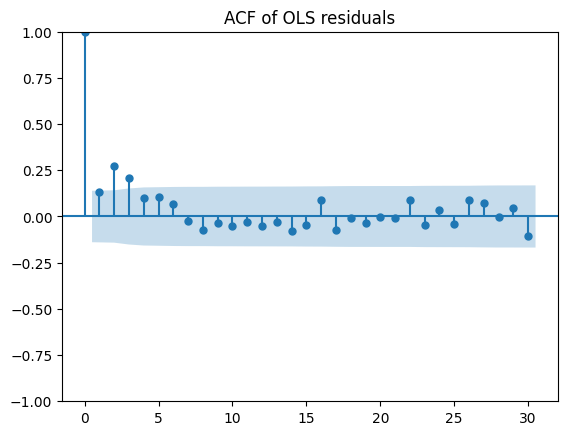

      lb_stat    lb_pvalue
--  ---------  -----------
10    35.0775  0.000121117
20    40.9876  0.00373886


In [17]:
plt.figure()
plot_acf(ols_model.resid, lags=30)
plt.title("ACF of OLS residuals")
plt.show()

lb = acorr_ljungbox(ols_model.resid, lags=[10, 20], return_df=True)
print(tabulate(lb, headers="keys"))


- The Durbin-Watson statistic is less than 2 indicating positive autocorrelation in the residuals.
- The ACF shows that the residuals exhibit significant positive autocorrelation at lags larger than 0 at a 95% level.
- The Ljung-Box test reject the null hypothesis of no autocorrelation at a 95% significance level.

Conclusion: the residuals are autocorrelated.

### B2. Choose an ARMA structure for the errors
- Use residual ACF and PACF to propose candidate ARMA($p$, $q$) orders for $e_t$ (start small).
- Fit a small grid of SARIMAX($y$, exog=$x$, order=($p$, 0, $q$), trend='c') models and compare BIC.
- Select a final ($p$, $q$) based on BIC + parsimony + residual whiteness.

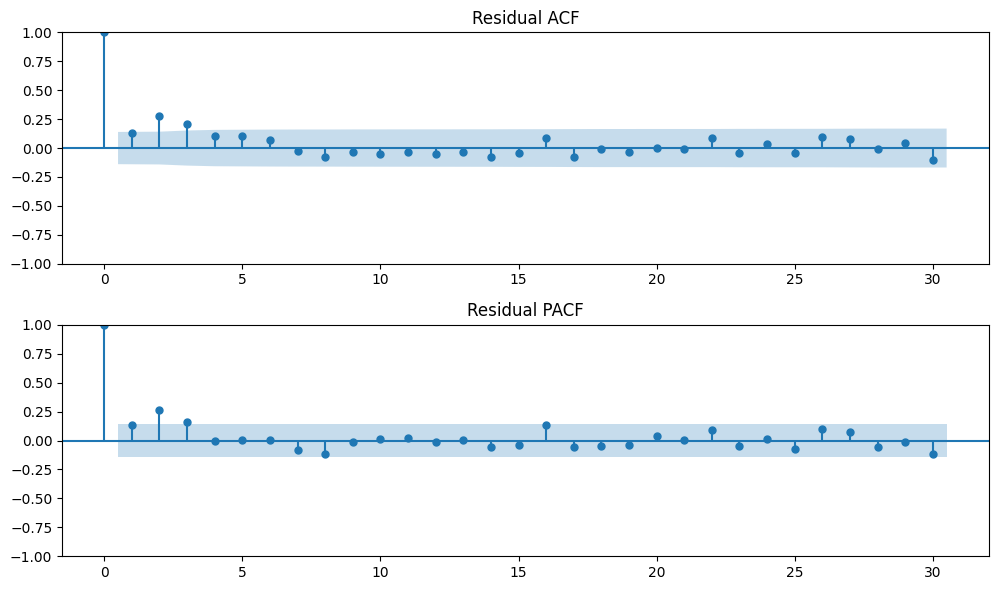

In [18]:
resid = ols_model.resid

fig, ax = plt.subplots(2, 1, figsize=(10,6))

plot_acf(resid, lags=30, ax=ax[0])
ax[0].set_title("Residual ACF")

plot_pacf(resid, lags=30, ax=ax[1])
ax[1].set_title("Residual PACF")

plt.tight_layout()
plt.show()

Based upon visual inspection of the drop off of the ACF and PACF plots the range [0; 3] is chosen for candidate orders for both $p$ and $q$.

In [20]:
p_vals = range(0, 4)
q_vals = range(0, 4)

results = []

warnings.filterwarnings("ignore")  # suppress convergence warnings

for p in p_vals:
    for q in q_vals:
        model = SARIMAX(
            y,
            exog=x,
            order=(p, 0, q),
            trend="c",
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        results.append({
            "p": p,
            "q": q,
            "AIC": res.aic,
            "BIC": res.bic
        })

results_df = pd.DataFrame(results).sort_values("BIC")
results_df.head(5)


,p,q,AIC,BIC
12,3,0,334.755602,354.393599
6,1,2,335.665357,355.303354
3,0,3,335.806323,355.413472
8,2,0,340.034855,356.425429
9,2,1,337.786476,357.455164


Orders $p=1$ and $q=2$ are chosen for simplicity and low AIC and BIC scores. Below is shown the whiteness of the residuals.

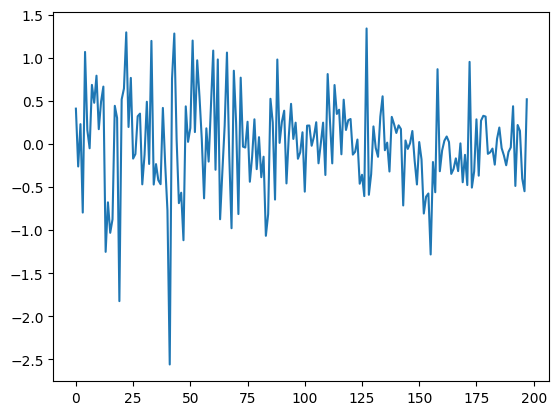

<Figure size 640x480 with 0 Axes>

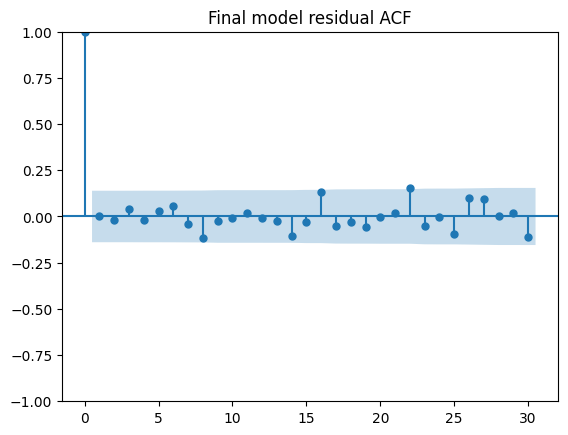

In [30]:
final_model = SARIMAX(
    y,
    exog=x,
    order=(1, 0, 2),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

plt.plot(final_model.resid)
plt.show()
plt.figure()
plot_acf(final_model.resid, lags=30)
plt.title("Final model residual ACF")
plt.show()

The ACF of the residuals of the fitted model are on visual inspection white and fall within the 95% confidence interval.

### B3. Fit the final regression-with-ARMA-errors model
- Fit SARIMAX with your chosen ($p$, $q$). Report $\beta$ and the AR/MA parameters (with $p$-values).
- Run residual/innovation diagnostics (ACF + Ljung–Box) to confirm whiteness.
- Compare $\beta$ from OLS vs SARIMAX: how did the estimate and/or standard error change, and why?

In [ ]:
final_model = SARIMAX(
    y,
    exog=x,
    order=(1, 0, 2),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

params = pd.DataFrame({
    "estimate": final_model.params,
    "std_error": final_model.bse,
    "p_value": final_model.pvalues
})

params

,estimate,std_error,p_value
intercept,0.181179,0.063527,4.344783e-03
Income,0.199226,0.034226,5.853010e-09
ar.L1,0.700232,0.107410,7.066138e-11
ma.L1,-0.611770,0.114656,9.516464e-08
ma.L2,0.210617,0.065122,1.219782e-03
sigma2,0.307265,0.023043,1.464737e-40


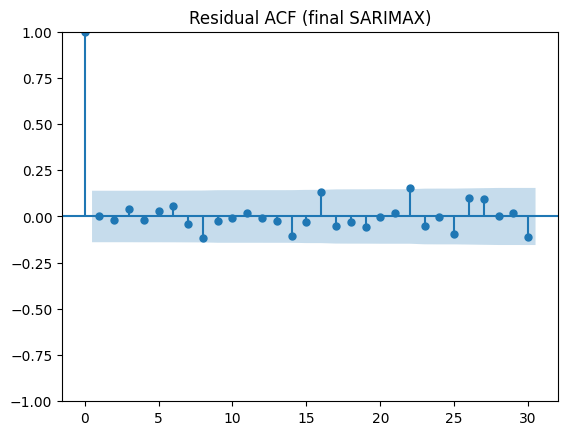

In [33]:
plot_acf(final_model.resid, lags=30)
plt.title("Residual ACF (final SARIMAX)")
plt.show()

In [34]:
acorr_ljungbox(final_model.resid, lags=[10,20], return_df=True)

,lb_stat,lb_pvalue
10,4.592230,0.916703
20,12.959991,0.879094


In [35]:
comparison = pd.DataFrame({
    "OLS": [ols_model.params[x_name], ols_model.bse[x_name]],
    "SARIMAX": [final_model.params[x_name], final_model.bse[x_name]]
}, index=["beta", "std_error"])

comparison

,OLS,SARIMAX
beta,0.271833,0.199226
std_error,0.046729,0.034226
